In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path("").resolve().parent.parent))

In [46]:
# 라이브러리
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

# 환경설정
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)      # 행 전체 표시
pd.set_option('display.max_columns', None)  # 열 전체 표시
pd.set_option('display.width', None)        # 가로폭 자동 맞춤
pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
pd.set_option('display.float_format', '{:.6f}'.format)

# 경로 설정
ROOT_DIR = Path("").resolve().parent.parent

# 데이터 경로
DATA_DIR = ROOT_DIR / "data"
DATA_PATH = DATA_DIR / "analy_data.csv"
SAVE_FILE = DATA_DIR / "prep_data_v1.csv"

# JSON 컬럼 관리 파일 로드
with open("modules/columns.json", "r", encoding="utf-8") as f:
    columns_dict = json.load(f)

# 공통 함수 
def get_columns(*categories):
    """columns.json의 카테고리별 use=y 컬럼 추출"""
    selected = []
    for cat in categories:
        for col, meta in columns_dict[cat].items():
            if meta.get("use", "n") == "y": 
                selected.append(col)
    
    if "churn" not in selected:
        selected.append("churn")

    if "exmprs_no" not in selected:
        selected.append("exmprs_no")

    return selected

def rename_to_kor(df):
    """columns.json의 name으로 한글 컬럼명 매핑"""
    rename_map = {
        col: meta["name"]
        for cat in columns_dict.values()
        for col, meta in cat.items()
        if col in df.columns
    }
    return df.rename(columns=rename_map)

# 1. 기본정보 + 가구조사 
def preprocess_basic_house(data_path):
    cols = get_columns("기본정보", "가구조사")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    if "CTPRVN_CODE" in df.columns:
        df['CTPRVN_CODE'] = df['CTPRVN_CODE'].apply(lambda x: x.split("'")[1])
    
    if "SPOT_NO" in df.columns:
        df['SPOT_NO'] = df['SPOT_NO'].apply(lambda x: x.split("'")[1])
    
    if "sex" in df.columns:
        df['sex'] = df['sex'].apply(lambda x: 1 if x == 1 else 2).astype(str)

    # NaN 변경
    for col in ["fma_04z1", "nue_01z1", "fma_27z1", "fma_26z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["fma_13z1", "fma_14z1"]:
        if col in df.columns:
            df.loc[df[col] >= 77777, col] = np.nan

    for col in ["fma_24z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 2. 식생활 + 비만및체중조절 + 구강건강
def preprocess_diet_obesity_oral(data_path):
    cols = get_columns("식생활", "비만및체중조절", "구강건강")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["nua_01z2", "nuc_02z1", "nuc_03z1", "obb_02a1", "obb_02b1", "obb_02d1", "ora_01z1", "orb_01z1", "ord_01d2", "ord_05z1", "ord_01f3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["ore_03z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 3. 음주 + 신체활동
def preprocess_drink_physical(data_path):
    cols = get_columns("음주", "신체활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # 값 변경
    if "drb_01z3" in df.columns:
        df["drb_01z3"] = df["drb_01z3"].replace(8, 1)

    if "drb_03z1" in df.columns:
        df["drb_03z1"] = df["drb_03z1"].replace(8, -1)

    # NaN 변경 
    for col in ["drb_01z3", "drb_03z1", "drg_01z3", "pha_11z1", "drb_04z1", "drb_05z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["pha_04z1", "pha_07z1", "phb_01z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 4. 정신건강 + 보건이용
def preprocess_mental_health(data_path):
    cols = get_columns("정신건강", "보건이용")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경 
    for col in ["mta_01z1", "mta_02z1", "mtc_08z1", "mtc_12c1", "mtc_12h1", "mtj_05z2", "mtj_10z1", "mtj_11z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["edit_mtc_03z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 5. 건강행태 + 교육및경제활동
def preprocess_behavior_education(data_path):
    cols = get_columns("건강행태", "교육및경제활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["smf_01z1", "sma_01z1", "sma_03z2", "smb_09z1", "sma_36z1", "sma_37z1", "sma_08z1", "sma_12z2"\
                "smd_02z3", "smd_01z3", "smc_08z2", "smc_09z2", "smc_10z2", "sob_02z1", "soa_01z1", "soa_07z1", "sod_02z3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["smb_02z1", "smb_05z1", "sma_11z2", "sob_01z1", "soa_06z2", "smb_12z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    for col in ["smb_01z1", "smb_13z1", "smb_03z1", "smb_04z1", "smb_06z1", "smb_11z1"]:
            if col in df.columns:
                df.loc[df[col] >= 777, col] = np.nan
    return df

df_basic = preprocess_basic_house(DATA_PATH)
df_health = preprocess_diet_obesity_oral(DATA_PATH)
df_drink = preprocess_drink_physical(DATA_PATH)
df_mental = preprocess_mental_health(DATA_PATH)
df_behavior = preprocess_behavior_education(DATA_PATH)

dfs = [df_basic, df_health, df_drink, df_mental, df_behavior]
df_merge = dfs[0]
for temp in dfs[1:]:
    join_cols = [c for c in ["exmprs_no", "churn"] if c in df_merge.columns and c in temp.columns]
    if join_cols:
        df_merge = pd.merge(df_merge, temp, on=join_cols, how="outer")

print("컬럼 식별 완료된 데이터 크기:", df_merge.shape,'-2')
print(f"결측치 비율: (평균) {df_merge.isna().mean().mean() * 100:.2f}%")

#=========================
# 추가 전처리
#=========================
# doyeon
#=========================
# '월간 폭음 경험(남)', '월간 폭음 경험(여)' ['drb_04z1', 'drb_05z1'] -> '월간 폭음 경험' ['drb_binge_monthly'] 통합
df_merge['sex'] = df_merge['sex']
df_merge['drb_binge_monthly'] = np.where(df_merge['sex'] == 1, df_merge['drb_04z1'], df_merge['drb_05z1'])
df_merge.drop(['drb_04z1', 'drb_05z1'], axis=1, inplace=True)

# 값변경
df_merge['drb_binge_monthly'] = df_merge['drb_binge_monthly'].replace(8, -1)
df_merge.loc[df_merge['drb_binge_monthly'] >= 7, 'drb_binge_monthly'] = np.nan

# 범주형 칼럼 object형 변환
df_merge['dra_01z1'] = df_merge['dra_01z1'].astype('object')

#=========================
# soso
#=========================
# 연령대
df_merge['age_group'] = (df_merge['age'] // 10) * 10

# 1인가구
df_merge['is_single'] = np.where((df_merge['mbhld_co'] <= 1), 1, 0)

# 월간소득 기준 가구소득컬럼 통합
df_merge['fma_14z1_add'] = df_merge['fma_14z1'] 
df_merge['fma_14z1_add'] = round(df_merge['fma_14z1_add'].fillna(df_merge['fma_13z1'] / 12))
df_merge['fma_14z1_log'] = np.log1p(df_merge['fma_14z1_add'])

bins = [0, 50, 100, 200, 300, 400, 500, 600, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
df_merge['fma_14z1_group'] = pd.cut(df_merge['fma_14z1_add'], bins=bins, labels=labels, right=False)
df_merge['fma_14z1_group'] = np.where(df_merge['fma_14z1_group'].isna(), df_merge['fma_24z2'].astype(float), df_merge['fma_14z1_group'])

# 치매가족여부
def get_dementia_case(row):
    if row['fma_27z1'] == 1 and row['fma_26z1'] == 1:
        return 1 # 치매가족 있음 + 같이 거주
    elif row['fma_27z1'] == 1 and row['fma_26z1'] == 2:
        return 2 # 치매가족 있음 + 비거주
    elif row['fma_27z1'] == 2:
        return 3 # 치매가족 없음
    else:
        return np.nan

df_merge['fma_dementia_case'] = df_merge.apply(get_dementia_case, axis=1)

# 일반담배일평균(단위: 개비)
df_merge['smb_avg_per_day'] = df_merge.apply(lambda x : x[['smb_01z1', 'smb_03z1', 'smb_06z1']].max(skipna=True), axis=1)

# 컬럼 삭제
df_merge.drop(['fma_13z1', 'fma_14z1','fma_27z1','fma_26z1','smb_01z1','smb_03z1','smb_06z1'], axis=1, inplace=True)

print("추가 전처리 후 데이터 크기:", df_merge.shape ,'-2')
print("exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용")

# 위 코드 실행 결과: df_merge
df_pre = df_merge.copy()
df_pre = df_pre.drop(['exmprs_no'], axis=1)

# 결측치 비율
def drop_missing_cols(df, threshold=0.6):
    ratio = df.isna().mean()
    drop_cols = ratio[ratio > threshold].index
    return drop_cols

# 상관계수 기반
def remove_high_corr(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    print(f"변수간 상관성 높은 변수: {len(drop_cols)}, {drop_cols}")
    return drop_cols

# 트리 기반 중요도
def tree_based_selection(X, y, top_n=50):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X, y)
    importances = pd.Series(model.feature_importances_, index=X.columns)
    selected = importances.sort_values(ascending=False).head(top_n).index.tolist()
    print(f"트리기반 상위 {top_n}개 변수")
    return selected

drop_cols = drop_missing_cols(df_pre)
df_pre = df_pre.drop(drop_cols, axis=1)

# 최종 피처 선택
fnl_col = df_pre.columns.tolist()
df = df_pre[fnl_col]

# 한글 매핑
df_merge_kor = rename_to_kor(df)
df = df_merge_kor.copy()

컬럼 식별 완료된 데이터 크기: (89822, 61) -2
결측치 비율: (평균) 26.31%
추가 전처리 후 데이터 크기: (89822, 60) -2
exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용


In [ ]:
if 'churn' in df.columns: TARGET_NM = 'churn'
else: TARGET_NM = '이탈여부'

import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# 데이터 분리
X = df.drop(TARGET_NM, axis=1)
X[X.select_dtypes(exclude=['number']).columns] = X.select_dtypes(exclude=['number']).astype(float)
y = df[TARGET_NM]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')

(71857, 49) (71857,) (17965, 49) (17965,) 



- 초기 파라미터 탐색

In [48]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier

# 교차검증
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

# 모델별 파라미터 탐색 함수
def init_param_decision_tree(trial):
    model = DecisionTreeClassifier(
        max_depth=trial.suggest_int("max_depth", 2, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        random_state=2
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()

def init_param_extra_trees(trial):
    model = ExtraTreesClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 2, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        random_state=2,
        n_jobs=-1
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()

def init_param_random_forest(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 2, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        random_state=2,
        n_jobs=-1
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()

def init_param_hgb(trial):
    model = HistGradientBoostingClassifier(
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        max_depth=trial.suggest_int("max_depth", 2, 20),
        max_iter=trial.suggest_int("max_iter", 50, 300),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 10, 50),
        l2_regularization=trial.suggest_float("l2_regularization", 0.0, 1.0),
        random_state=2
    )
    return cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc").mean()

# 실행
studies = {}
objectives = {
    "DecisionTree": init_param_decision_tree,
    "ExtraTrees": init_param_extra_trees,
    "RandomForest": init_param_random_forest,
    "HistGradientBoosting": init_param_hgb
}

for name, obj_func in objectives.items():
    print(f"\n===== {name} 최적화 =====")
    study = optuna.create_study(direction="maximize")
    study.optimize(obj_func, n_trials=30, show_progress_bar=False)
    studies[name] = study

# 결과 저장
best_params = []
for name, study in studies.items():
    best_params.append({
        "모델": name,
        "최적파라미터": study.best_params,
        "BEST_ROC_AUC": study.best_value
    })

df_best = pd.DataFrame(best_params)

[I 2025-10-13 23:41:48,087] A new study created in memory with name: no-name-baefcbef-7bcd-46cf-9b27-e1c29858b182



===== DecisionTree 최적화 =====


[I 2025-10-13 23:41:49,766] Trial 0 finished with value: 0.774858063068562 and parameters: {'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.774858063068562.
[I 2025-10-13 23:41:51,336] Trial 1 finished with value: 0.7750005280968391 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7750005280968391.
[I 2025-10-13 23:41:53,196] Trial 2 finished with value: 0.7534759446596819 and parameters: {'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7750005280968391.
[I 2025-10-13 23:41:53,742] Trial 3 finished with value: 0.7166805072301621 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7750005280968391.
[I 2025-10-13 23:41:54,151] Trial 4 finished with value: 0.6883110173428998 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with val


===== ExtraTrees 최적화 =====


[I 2025-10-13 23:42:37,253] Trial 0 finished with value: 0.7950198175307007 and parameters: {'n_estimators': 190, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7950198175307007.
[I 2025-10-13 23:42:38,536] Trial 1 finished with value: 0.7697330609177468 and parameters: {'n_estimators': 112, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7950198175307007.
[I 2025-10-13 23:42:41,844] Trial 2 finished with value: 0.8057789147762852 and parameters: {'n_estimators': 145, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8057789147762852.
[I 2025-10-13 23:42:43,052] Trial 3 finished with value: 0.7988294904271275 and parameters: {'n_estimators': 55, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8057789147762852.
[I 2025-10-13 23:42:46,511] Trial 4 finished with value: 0.782983491394237 and parameters: {'


===== RandomForest 최적화 =====


[I 2025-10-13 23:45:46,727] Trial 0 finished with value: 0.812505572502098 and parameters: {'n_estimators': 169, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.812505572502098.
[I 2025-10-13 23:45:50,274] Trial 1 finished with value: 0.7980363804736258 and parameters: {'n_estimators': 185, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.812505572502098.
[I 2025-10-13 23:45:58,454] Trial 2 finished with value: 0.8123636401130353 and parameters: {'n_estimators': 265, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.812505572502098.
[I 2025-10-13 23:46:05,744] Trial 3 finished with value: 0.8098538378785233 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.812505572502098.
[I 2025-10-13 23:46:09,939] Trial 4 finished with value: 0.7875379378330188 and parameters: {'n_es


===== HistGradientBoosting 최적화 =====


[I 2025-10-13 23:49:23,674] Trial 0 finished with value: 0.8236213222526608 and parameters: {'learning_rate': 0.14070765894760237, 'max_depth': 8, 'max_iter': 128, 'min_samples_leaf': 14, 'l2_regularization': 0.7657063370311374}. Best is trial 0 with value: 0.8236213222526608.
[I 2025-10-13 23:49:27,530] Trial 1 finished with value: 0.8234632627226278 and parameters: {'learning_rate': 0.13113963896259168, 'max_depth': 18, 'max_iter': 237, 'min_samples_leaf': 36, 'l2_regularization': 0.826365701409349}. Best is trial 0 with value: 0.8236213222526608.
[I 2025-10-13 23:49:33,250] Trial 2 finished with value: 0.8182318097081129 and parameters: {'learning_rate': 0.02980132572970822, 'max_depth': 16, 'max_iter': 143, 'min_samples_leaf': 50, 'l2_regularization': 0.3199781301225094}. Best is trial 0 with value: 0.8236213222526608.
[I 2025-10-13 23:49:36,429] Trial 3 finished with value: 0.8219726075695816 and parameters: {'learning_rate': 0.16683259216854715, 'max_depth': 19, 'max_iter': 114, 

In [51]:
df_best

,모델,최적파라미터,BEST_ROC_AUC
0,DecisionTree,"{'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}",0.775038
1,ExtraTrees,"{'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2}",0.808782
2,RandomForest,"{'n_estimators': 299, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 5}",0.814023
3,HistGradientBoosting,"{'learning_rate': 0.09929613243547233, 'max_depth': 5, 'max_iter': 300, 'min_samples_leaf': 29, 'l2_regularization': 0.3378944177263832}",0.824888


In [52]:
# 모델 정의
dt_params = df_best[df_best['모델'] == 'DecisionTree']['최적파라미터'].item()
et_params = df_best[df_best['모델'] == 'ExtraTrees']['최적파라미터'].item()
rf_params = df_best[df_best['모델'] == 'RandomForest']['최적파라미터'].item()
hgb_params = df_best[df_best['모델'] == 'HistGradientBoosting']['최적파라미터'].item()

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=2, **dt_params),
    "ExtraTrees": ExtraTreesClassifier(random_state=2, **et_params),
    "RandomForest": RandomForestClassifier(random_state=2, **rf_params),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=2, **hgb_params)
}

# 학습 및 평가
results = []
for name, model in models.items():
    
    start = time.perf_counter()
    model.fit(X_train, y_train)
    train_time_sec = time.perf_counter() - start
    print(f"{name} | 학습시간(초): {train_time_sec:.3f}")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    results.append((name, acc, auc, pr_auc))

# 결과 저장
df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC_AUC', 'PR_AUC']).sort_values('ROC_AUC', ascending=False)
print('\n')
print(df_results)

DecisionTree | 학습시간(초): 0.996
ExtraTrees | 학습시간(초): 52.999
RandomForest | 학습시간(초): 47.997
HistGradientBoosting | 학습시간(초): 1.821


                  Model  Accuracy  ROC_AUC   PR_AUC
3  HistGradientBoosting  0.745394 0.824677 0.852164
2          RandomForest  0.736432 0.814020 0.840616
1            ExtraTrees  0.733871 0.810531 0.835022
0          DecisionTree  0.710214 0.780602 0.798101


- GridSearchCV

In [ ]:
# # 베스트 모델  
# best_model = df_best[df_best['BEST_ROC_AUC']==df_best['BEST_ROC_AUC'].max()]['모델'].item()

# # 파라미터 후보
# param_grid = {}
# best_params = df_best[df_best['BEST_ROC_AUC']==df_best['BEST_ROC_AUC'].max()]['최적파라미터'].item()
# for param in best_params.keys():
#     param_1 = int(best_params[param]*0.7) if param not in ('learning_rate', 'l2_regularization') else best_params[param]*0.7
#     param_2 = best_params[param]
#     param_3 = int(best_params[param]*1.5) if param not in ('learning_rate', 'l2_regularization') else best_params[param]*1.5
#     param_grid[param] = [param_1, param_2, param_3]

# # GridSearchCV 설정
# grid = GridSearchCV(
#     estimator=models[best_model],
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # 학습
# grid.fit(X_train, y_train)

# # 최적 모델
# best_model = grid.best_estimator_
# print("Best Params:", grid.best_params_)
# print("Best CV Score:", grid.best_score_)

# # 평가
# y_pred = best_model.predict(X_test)
# print("Test Accuracy:", accuracy_score(y_test, y_pred))

In [66]:
# GridSearchCV, cross_val_score
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
import numpy as np
import time

# 베스트 모델  
best_model = df_best[df_best['BEST_ROC_AUC']==df_best['BEST_ROC_AUC'].max()]['모델'].item()

# 파라미터 후보
param_grid = {}
best_params = df_best[df_best['BEST_ROC_AUC']==df_best['BEST_ROC_AUC'].max()]['최적파라미터'].item()
for param in best_params.keys():
    param_1 = int(best_params[param]*0.7) if param not in ('learning_rate', 'l2_regularization') else best_params[param]*0.7
    param_2 = best_params[param]
    param_3 = int(best_params[param]*1.5) if param not in ('learning_rate', 'l2_regularization') else best_params[param]*1.5
    param_grid[param] = [param_1, param_2]
    
# 파라미터 조합 생성
param_list = list(ParameterGrid(param_grid))
print(f"총 {len(param_list)}개 조합 탐색\n")

best_score = -1
best_params_ = None
best_model_ = None

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

for i, params in enumerate(param_list, 1):
    
    print(f"[{i}/{len(param_list)}] 현재 파라미터: {params}")
    start_time = time.time()
    
    # 최적 모델
    model = models[best_model].set_params(**params)
    acc_list, auc_list, pr_auc_list = [], [], []
    
    # 교차검증 수행 (5-Fold)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_prob)
        pr_auc = average_precision_score(y_val, y_prob)

        acc_list.append(acc)
        auc_list.append(auc)
        pr_auc_list.append(pr_auc)

        print(f"Fold {fold}: acc={acc:.4f}, auc={auc:.4f}, pr_auc={pr_auc:.4f}")
    
    mean_acc = np.mean(acc_list)
    mean_auc = np.mean(auc_list)
    mean_pr_auc = np.mean(pr_auc_list)
    elapsed = time.time() - start_time

    print(f"평균 acc={mean_acc:.4f}, auc={mean_auc:.4f}, pr_auc={mean_pr_auc:.4f} | 소요시간: {elapsed:.1f}초\n")

    # 최고 모델 업데이트(AUC 기준)
    if mean_auc > best_score:
        best_score = mean_auc
        best_params_ = params
        best_model_ = model

print("탐색 완료")
print("Best Params:", best_params_)
print("Best Test Accuracy:", best_score)

총 32개 조합 탐색

[1/32] 현재 파라미터: {'l2_regularization': 0.2365260924084682, 'learning_rate': 0.06950729270483062, 'max_depth': 3, 'max_iter': 210, 'min_samples_leaf': 20}
Fold 1: acc=0.7402, auc=0.8181, pr_auc=0.8436
Fold 2: acc=0.7513, auc=0.8280, pr_auc=0.8547
Fold 3: acc=0.7384, auc=0.8169, pr_auc=0.8432
Fold 4: acc=0.7455, auc=0.8240, pr_auc=0.8514
Fold 5: acc=0.7411, auc=0.8176, pr_auc=0.8430
평균 acc=0.7433, auc=0.8209, pr_auc=0.8472 | 소요시간: 5.3초

[2/32] 현재 파라미터: {'l2_regularization': 0.2365260924084682, 'learning_rate': 0.06950729270483062, 'max_depth': 3, 'max_iter': 210, 'min_samples_leaf': 29}
Fold 1: acc=0.7401, auc=0.8179, pr_auc=0.8435
Fold 2: acc=0.7507, auc=0.8280, pr_auc=0.8548
Fold 3: acc=0.7378, auc=0.8170, pr_auc=0.8435
Fold 4: acc=0.7452, auc=0.8243, pr_auc=0.8517
Fold 5: acc=0.7413, auc=0.8177, pr_auc=0.8433
평균 acc=0.7430, auc=0.8210, pr_auc=0.8474 | 소요시간: 5.1초

[3/32] 현재 파라미터: {'l2_regularization': 0.2365260924084682, 'learning_rate': 0.06950729270483062, 'max_depth': 3,

In [67]:
print("탐색 완료")
print("Best Params:", best_params_)
print("Best Test Accuracy:", best_score)

탐색 완료
Best Params: {'l2_regularization': 0.2365260924084682, 'learning_rate': 0.06950729270483062, 'max_depth': 5, 'max_iter': 300, 'min_samples_leaf': 29}
Best Test Accuracy: 0.8266685619841612


In [70]:
# 최적 모델 재학습 및 평가
best_model_.fit(X_train, y_train)

# test
y_pred = best_model_.predict(X_test)
y_prob = best_model_.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc_roc = roc_auc_score(y_test, y_prob)
test_pr_auc = average_precision_score(y_test, y_prob)

# train
train_y_pred = best_model_.predict(X_train)
train_y_prob = best_model_.predict_proba(X_train)[:, 1]

train_acc = accuracy_score(y_train, train_y_pred)
train_auc_roc = roc_auc_score(y_train, train_y_prob)
train_pr_auc = average_precision_score(y_train, train_y_prob)

print(f"\n학습 성능: train_acc={train_acc:.4f}, train_auc_roc={train_auc_roc:.4f}, train_pr_auc={train_pr_auc:.4f}")
print(f"\n평가 성능: test_acc={test_acc:.4f}, test_auc_roc={test_auc_roc:.4f}, test_pr_auc={test_pr_auc:.4f}") # 테스트 셋으로


학습 성능: train_acc=0.7695, train_auc_roc=0.8534, train_pr_auc=0.8768

평가 성능: test_acc=0.7454, test_auc_roc=0.8247, test_pr_auc=0.8522


Accuracy: 0.7453938213192318


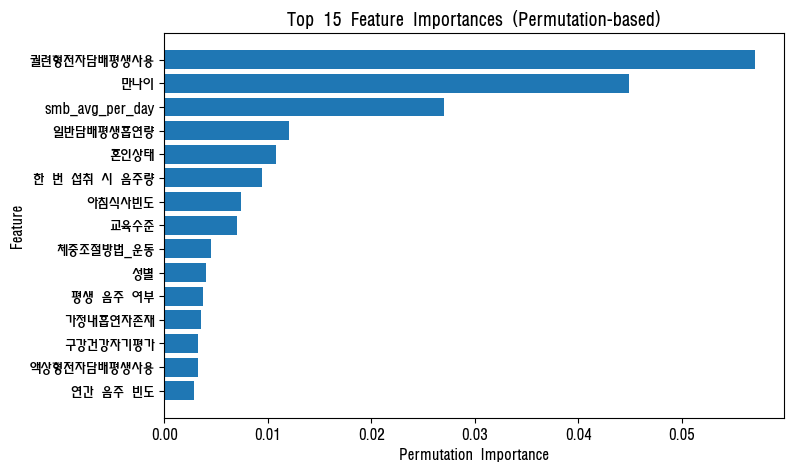

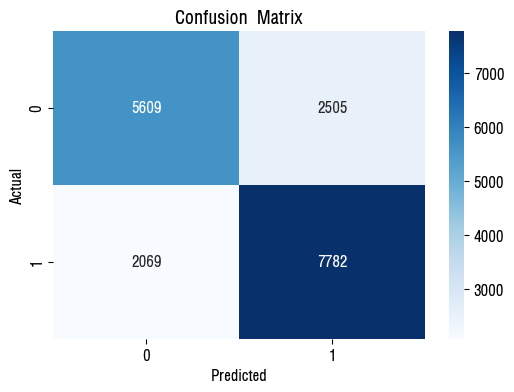

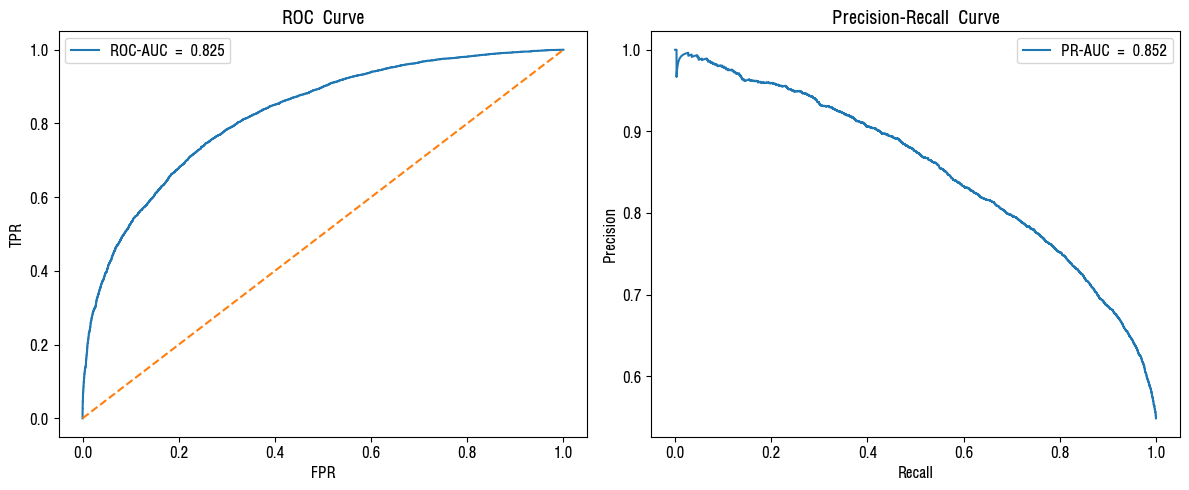

In [73]:
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = r'C:\Windows\Fonts\HMFMMUEX.TTC'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 예측 및 평가
y_pred = best_model_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 변수중요도
result = permutation_importance(best_model_, X_test, y_test, n_repeats=10, random_state=2, n_jobs=-1)

# 중요도 정렬
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(X_test.columns)[sorted_idx][:15], result.importances_mean[sorted_idx][:15])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances (Permutation-based)")
plt.gca().invert_yaxis()
plt.show()

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
y_prob = best_model_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
prec, recall, _ = precision_recall_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--')
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()

axes[1].plot(recall, prec, label=f"PR-AUC = {pr_auc:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()